# Nested sampling for an SED with only photometry

Forward modeling an observed SED composed of only photometric data points using the ``dynesty`` Bayesian framework and modern atmospheric models.

In [1]:
import seda # import the seda package
import importlib
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, AutoMinorLocator, StrMethodFormatter, NullFormatter
from astropy.io import fits, ascii
from dynesty import plotting as dyplot # to plot nested sampling results


    SEDA v0.4.0 package imported


Read photometry of interest.

As an example here, let's read near- and mid-infrared magnitudes from different surveys (2MASS, Spitzer/IRAC, WISE, and JWST/MIRI) for the T8 (~750 K) brown dwarf 2MASS J04151954-0935066, as compiled in [Alejandro Merchan et al. (2025)](https://ui.adsabs.harvard.edu/abs/2025ApJ...989...80A/abstract):

In [2]:
# path to the seda package
path_seda = os.path.dirname(os.path.dirname(seda.__file__))

# read table with photometry
phot_file = path_seda+'/docs/notebooks/data/0415-0935_photometry.dat'
photometry = ascii.read(phot_file)

# keep columns with magnitudes of interest
photometry.remove_column('WISE_designation') # remove only columns without photometry

# convert table with photometry to a dictionary with three keys: filters, photometry, and uncertainties
# save output dictionary as a fancy ascii table in the seda directory "data"
# the output table can be open using "seda.read_prettytable"
table_name = path_seda+'/docs/notebooks/data/0415-0935_photometry_prettytable.dat'
out = seda.utils.convert_photometric_table(photometry, save_table=True, 
                                           table_name=table_name)
phot = out['phot']
ephot = out['ephot']
filters = out['filters']

See restructured table:

In [3]:
seda.utils.read_prettytable(table_name)

{'filters': array(['2MASS/2MASS.J', '2MASS/2MASS.H', '2MASS/2MASS.Ks',
        'Spitzer/IRAC.I1', 'Spitzer/IRAC.I2', 'Spitzer/IRAC.I3',
        'Spitzer/IRAC.I4', 'WISE/WISE.W1', 'WISE/WISE.W2', 'WISE/WISE.W3',
        'WISE/WISE.W4', 'JWST/MIRI.F1000W', 'JWST/MIRI.F1280W',
        'JWST/MIRI.F1800W'], dtype='<U16'),
 'phot': array([15.695, 15.537, 15.429, 14.256, 12.374, 12.87 , 12.11 , 15.148,
        12.305, 11.093,  8.24 , 10.768, 10.439, 10.36 ]),
 'ephot': array([0.058, 0.113, 0.201, 0.019, 0.017, 0.07 , 0.05 , 0.026, 0.011,
        0.125, 0.   , 0.002, 0.002, 0.007])}

Plot photometric SED to verify everything looks okay.

First convert magnitudes into fluxes:

In [5]:
# mag to flux
out_mag_to_flux = seda.synthetic_photometry.mag_to_flux(mag=phot, emag=ephot, filters=filters, 
                                                        flux_unit='erg/s/cm2/A')
#                                                       flux_unit='Jy')
flux = out_mag_to_flux['flux'] # in erg/s/cm2/A
eflux = out_mag_to_flux['eflux'] # in erg/s/cm2/A
wl_eff = out_mag_to_flux['lambda_eff_SVO(um)'] # effective wavelength in um
width_eff = out_mag_to_flux['width_eff_SVO(um)'] # effective width in um
filters = out_mag_to_flux['filters']

Plot SED

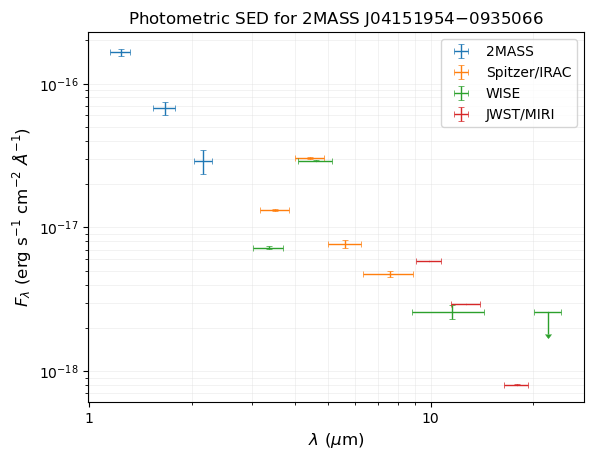

In [6]:
fig, ax = plt.subplots()

# select 2MASS magnitudes
mask_2MASS = ['2MASS' in filt for filt in filters]
ax.errorbar(wl_eff[mask_2MASS], flux[mask_2MASS], xerr=width_eff[mask_2MASS]/2, 
            yerr=eflux[mask_2MASS], fmt='.', markersize=1., capsize=2, 
            elinewidth=1.0, markeredgewidth=0.5, label='2MASS')

# select IRAC magnitudes
mask_IRAC = ['IRAC' in filt for filt in filters]
ax.errorbar(wl_eff[mask_IRAC], flux[mask_IRAC], xerr=width_eff[mask_IRAC]/2, 
            yerr=eflux[mask_IRAC], fmt='.', markersize=1., capsize=2, 
            elinewidth=1.0, markeredgewidth=0.5, label='Spitzer/IRAC')

# select WISE magnitudes
mask_WISE = ['WISE' in filt for filt in filters]
# handle upper limits
uplims = (ephot==0) * 1 # upper limits (null errors) indicated by 1
eflux[eflux==0] = 0.3*flux[eflux==0] # size of the arrow indicating upper limits
# plot WISE with upper limits
ax.errorbar(wl_eff[mask_WISE], flux[mask_WISE], xerr=width_eff[mask_WISE]/2, 
            yerr=eflux[mask_WISE], fmt='.', markersize=1., capsize=2, 
            elinewidth=1.0, markeredgewidth=0.5, label='WISE',
            uplims=uplims[mask_WISE])

# select MIRI magnitudes
mask_JWST = ['JWST' in filt for filt in filters]
ax.errorbar(wl_eff[mask_JWST], flux[mask_JWST], xerr=width_eff[mask_JWST]/2, 
            yerr=eflux[mask_JWST], fmt='.', markersize=1., capsize=2, 
            elinewidth=1.0, markeredgewidth=0.5, label='JWST/MIRI')

ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
plt.xscale('log')
plt.yscale('log')
ax.xaxis.set_major_formatter(StrMethodFormatter('{x:.0f}'))

ax.grid(True, which='both', color='gainsboro', linewidth=0.5, alpha=0.5)
ax.legend()

plt.title('Photometric SED for 2MASS J04151954$-$0935066')
plt.xlabel(r'$\lambda\ (\mu$m)', size=12)
plt.ylabel(r'$F_\lambda\ ($erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$)', size=12)

plt.show()

**Read input data**

Look at the input parameters [here](https://seda.readthedocs.io/en/latest/api.html#seda.input_parameters.InputData).

For any SEDA function, we can also see the function description directly on the notebook with the command ``help()``, e.g.:

``help(seda.input_parameters.InputData)``

In [7]:
# input photometry
phot = phot
ephot = ephot
filters = filters
phot_unit = 'mag'

# distance to the target (optional and used to derive a radius)
distance = 5.71 # pc (parallax=175.2+-1.7; Dupuy-Liu2012)
edistance = 0.06 # pc

# load all the input data parameters
my_data = seda.input_parameters.InputData(phot=phot, ephot=ephot, filters=filters, phot_unit=phot_unit,
                                          distance=distance, edistance=edistance, fit_spectra=False, 
                                          fit_photometry=True)

Null photometric errors for ['WISE/WISE.W4'] magnitudes, so they will be discarded.

   Input data loaded successfully:
      13 magnitudes


Download (if not yet) the atmospheric models you want to use. 

Use the commands below to see the available atmospheric models, the links to download them, and other relevant information from models. You can read more about the model [here](https://seda.readthedocs.io/en/latest/overview.html#available-atmospheric-models).

Also consider [this tutorial](https://seda.readthedocs.io/en/latest/notebooks/tutorial_models_examination.html) to explore the free parameters in the models and their coverage.

In [8]:
# available atmospheric models
seda.models.Models().available_models

['BT-Settl',
 'ATMO2020',
 'Sonora_Elf_Owl',
 'SM08',
 'Sonora_Bobcat',
 'Sonora_Diamondback',
 'Sonora_Cholla',
 'LB23']

In [9]:
# let's consider the ATMO 2020 models in this tutorial
# some parameters of interest from the selected model grid
model = 'ATMO2020'
print(seda.models.Models(model).ref) # reference
print(seda.models.Models(model).ADS) # link to paper
print(seda.models.Models(model).download) # link to download the models
seda.models.Models(model).params_unique # coverage of free parameters in the grid

Phillips et al. (2020)
https://ui.adsabs.harvard.edu/abs/2020A%26A...637A..38P/abstract
https://noctis.erc-atmo.eu/fsdownload/zyU96xA6o/phillips2020


{'Teff': array([ 200.,  250.,  300.,  350.,  400.,  450.,  500.,  550.,  600.,
         700.,  800.,  900., 1000., 1100., 1200., 1300., 1400., 1500.,
        1600., 1700., 1800., 1900., 2000., 2100., 2200., 2300., 2400.,
        2500., 2600., 2700., 2800., 2900., 3000.]),
 'logg': array([2.5, 3. , 3.5, 4. , 4.5, 5. , 5.5]),
 'logKzz': array([0., 4., 6.])}

**Read model grid options**

Look at the input parameters [here](https://seda.readthedocs.io/en/latest/api.html#seda.input_parameters.ModelOptions).

In [11]:
# select the atmospheric models of interest
model = 'ATMO2020'

# path to the directory or directories containing the model spectra
# (update it to your own path)'
model_dir = ['/home/gsuarez/TRABAJO/MODELS/atmosphere_models/ATMO2020/atmosphere_models/CEQ_spectra/',
             '/home/gsuarez/TRABAJO/MODELS/atmosphere_models/ATMO2020/atmosphere_models/NEQ_weak_spectra/',
             '/home/gsuarez/TRABAJO/MODELS/atmosphere_models/ATMO2020/atmosphere_models/NEQ_strong_spectra/',
            ]

# set parameter ranges to select a grid subset and to be used as uniform priors
# when a free parameter range is not specified, the whole grid range will be explored
params_ranges = {
    'Teff': [700, 800], # Teff range
    'logg': [4.0, 5.0] # logg range
}

# load model options
my_model = seda.input_parameters.ModelOptions(model=model, model_dir=model_dir, 
                                              params_ranges=params_ranges)


   Model options loaded successfully


**Tip:** If you plan to model several photometric SEDs obtained with the same filters, it is possible to save the synthetic photometry derived from model spectra during the modeling to reuse it and make subsequent fits much faster. For this, set the parameter ``path_save_syn_phot`` in ``seda.ModelOptions`` above to a folder path where you want to store the derived synthetic photometry. Once the photometry has been stored, the next time you run the code just replace ``model_dir`` by the path used in ``path_save_syn_phot`` and set ``skip_syn_phot=True`` to avoid the calculation of synthetic photometry.

**Read Bayes fit options**

Look at the input parameters [here](https://seda.readthedocs.io/en/latest/api.html#seda.input_parameters.BayesOptions).

Consider the default full wavelength range of each input spectrum for the fits. Otherwise, we can use the parameter ``fit_wl_range`` to set different fit ranges. 

In [12]:
# choose a filename (optional) to save the sampling results as a pickle file
# it is convenient to set a non-default name when running 
# the code several times in the same folder to avoid overwriting results
bayes_pickle_file = f'{model}_bayesian_sampling_photometry_only.pickle'

# radius range for the sampling
R_range = np.array((0.6, 1.0)) # Rjup

my_bayes = seda.input_parameters.BayesOptions(my_data=my_data, my_model=my_model, 
                                              R_range=R_range, fit_phot_range=[2, 10],
                                              bayes_pickle_file=bayes_pickle_file)


      8 of 13 input valid magnitudes within the fit range "fit_phot_range"

      18 model spectra selected with:
         Teff range = [700, 800]
         logg range = [4.0, 5.0]


Deriving synthetic photometry from model spectra:   0%|          | 0/18 [00:00<?, ?it/s]

      elapsed time: 1.3 min


UnboundLocalError: local variable 'wl_spectra_fit' referenced before assignment

**Run nested sampling**

In [62]:
out_bayes = seda.bayes_fit.bayes(my_bayes)


   Estimate Bayesian posteriors

      Uniform priors:
         Teff range = [700. 700.]
         logg range = [4.5 5. ]
         logKzz range = [0. 6.]
         R range = [0.6 1. ]

   Starting dynesty...


21560it [02:04, 173.21it/s, batch: 6 | bound: 8 | nc: 1 | ncall: 85244 | eff(%): 25.085 | loglstar: -6524.396 < -6518.120 < -6519.795 | logz: -6539.086 +/-  0.126 | stop:  0.840]       

      Bayesian sampling results saved successfully

   Bayesian sampling ran successfully
      elapsed time: 2.1 min


**Plot results**

The ``out_bayes`` output above from ``seda.bayes_fit.bayes()`` is the input file to make plots.

If ``out_bayes`` is not in memory (if we reloaded the notebook or restarted the kernel), we need to open the pickle file first as below.

In [63]:
# open pickle file
bayes_pickle_file = 'ATMO2020_bayesian_sampling_photometry_only.pickle'
with open(bayes_pickle_file, 'rb') as file:
    # deserialize and retrieve the variable from the file
    out_bayes = pickle.load(file)

print('Posteriors loaded successfully')

Posteriors loaded successfully


/home/gsuarez/TRABAJO/PROGRAMS/Anaconda/anaconda3/lib/python3.9/site-packages/dynesty/plotting.py:1320: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(span[i])


Quantiles:
Teff [(0.025, 700.0), (0.5, 700.0), (0.975, 700.0)]
Quantiles:
logg [(0.025, 4.5000041955751495), (0.5, 4.500110587117586), (0.975, 4.500595442168182)]
Quantiles:
logKzz [(0.025, 5.995131368451749), (0.5, 5.99907640411101), (0.975, 5.999965205669575)]


/home/gsuarez/TRABAJO/PROGRAMS/Anaconda/anaconda3/lib/python3.9/site-packages/dynesty/plotting.py:2392: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(span[0])


Quantiles:
R [(0.025, 0.9759898548191283), (0.5, 0.9772731655223263), (0.975, 0.9785701423130575)]


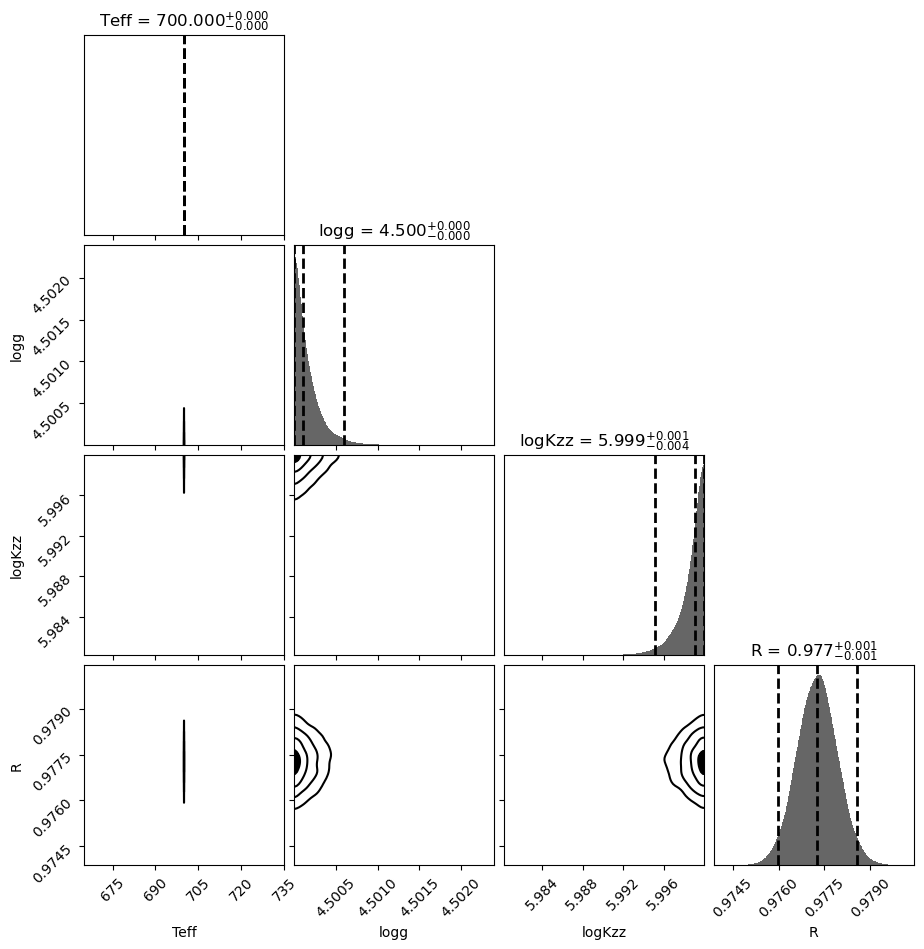

In [13]:
# plot the 2-D marginalized posteriors.
labels = list(out_bayes['my_bayes'].params_priors.keys())
fig, axes = dyplot.cornerplot(out_bayes['out_dynesty'], show_titles=True, 
                              verbose='true', title_fmt='.3f', 
                              title_kwargs={'y': 1.0}, labels=labels)

Plot a summary of the run

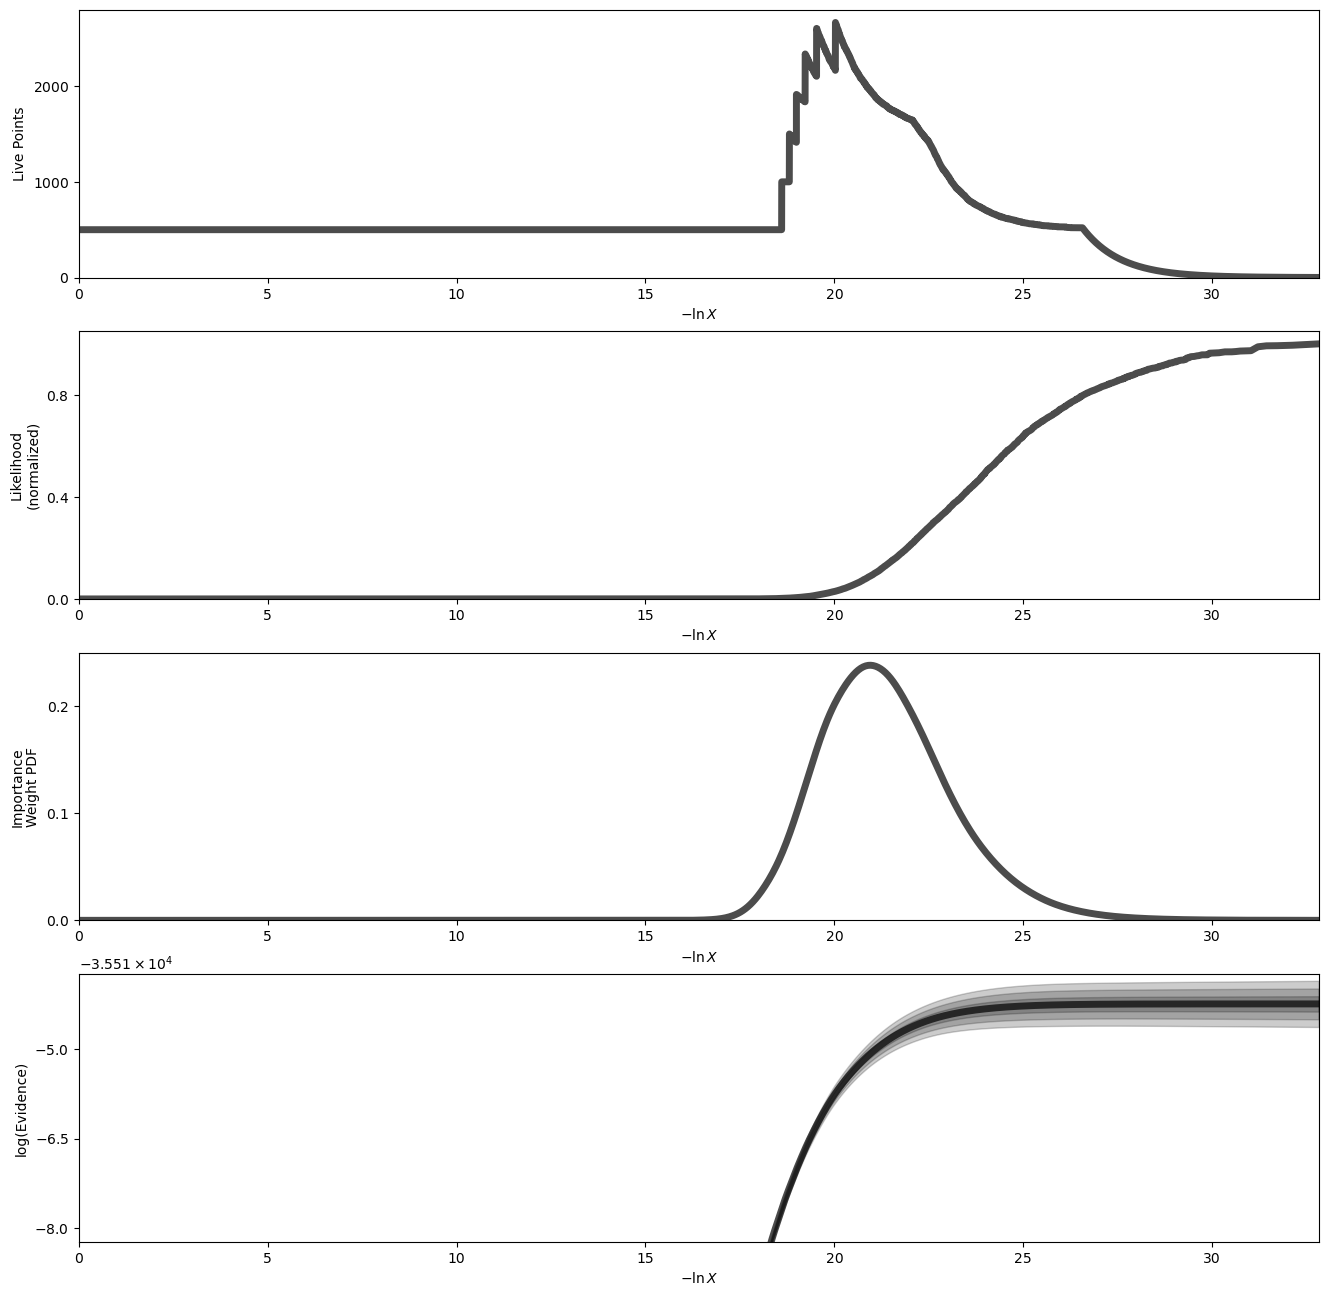

In [14]:
fig, axes = dyplot.runplot(out_bayes['out_dynesty'], color='black', 
                           mark_final_live=False, logplot=True)

Plot traces and 1-D marginalized posteriors

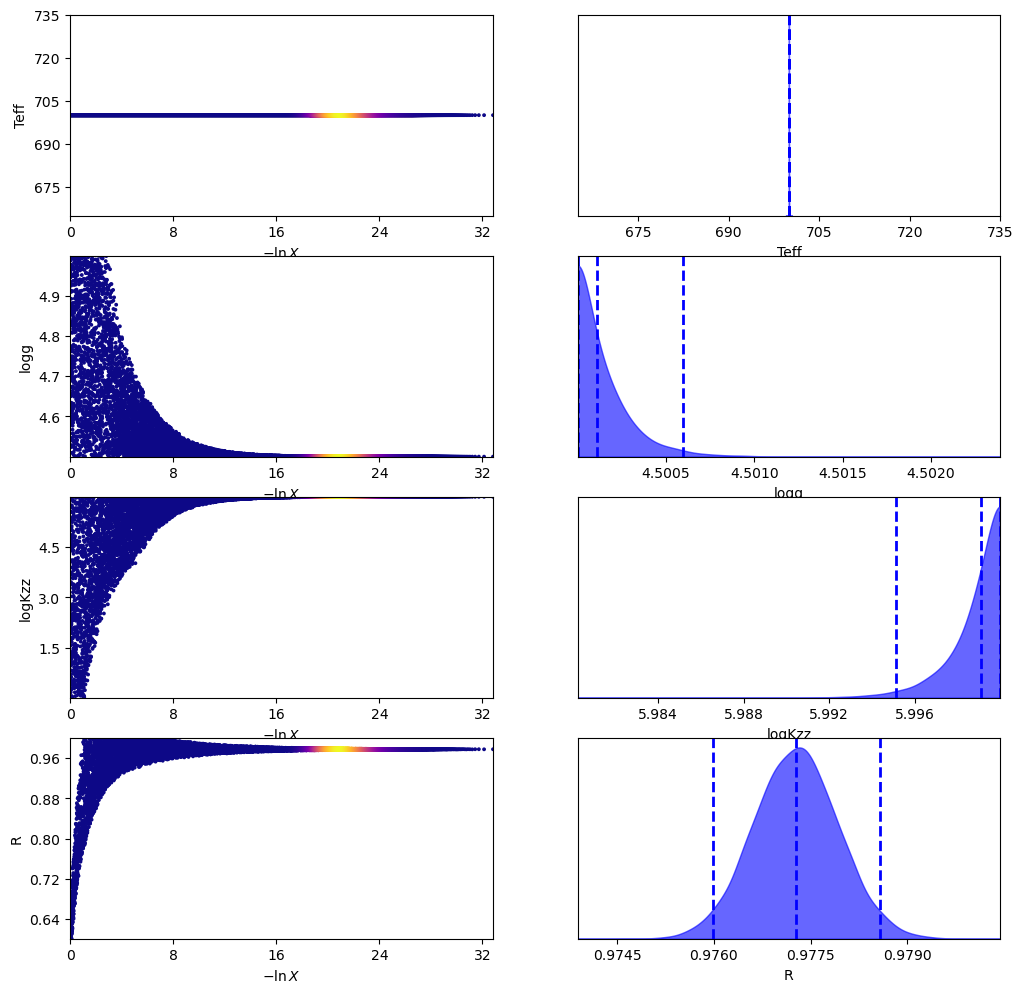

In [16]:
fig, axes = dyplot.traceplot(out_bayes['out_dynesty'], labels=labels)

**Plot the model spectrum using the median posterior parameters**

SED with the best model fit from the Bayesian sampling.

The pickle file generated by ``seda.bayes_fit.bayes`` and stored with the name ``my_bayes.bayes_pickle_file`` is the input file to make plots. We can provide the name by either using ``my_bayes.bayes_pickle_file`` (if ``my_bayes`` is in memory) or just typing it.

The best model fit will be generated by interpolating into a model grid subset around the median posteriors.

*Note that the Elf Owl models do not cover wavelenghts longer than 15 microns.*


      1 model spectra selected with:
         Teff range = [700. 700.]
         logg range = [4.5 4.5]
         logKzz range = [6. 6.]


Deriving synthetic photometry from model spectra:   0%|          | 0/1 [00:00<?, ?it/s]

      elapsed time: 2.0 s

      510 model spectra

      1 model spectra selected with:
         Teff range = [700. 700.]
         logg range = [4.5 4.5]
         logKzz range = [6. 6.]


Reading model grid:   0%|          | 0/1 [00:00<?, ?it/s]

      elapsed time: 0.0 s


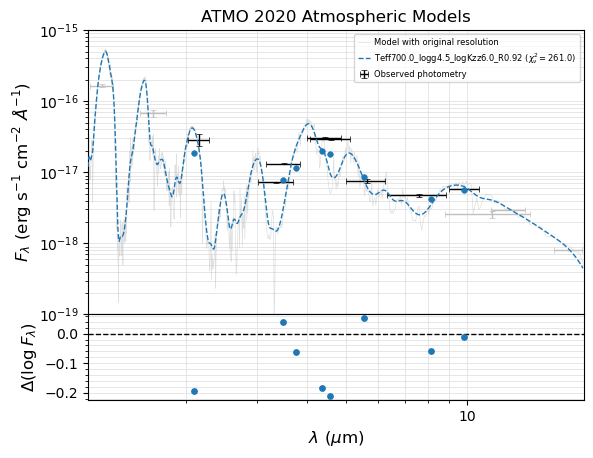

In [129]:
importlib.reload(seda.plots)
importlib.reload(seda.utils)
importlib.reload(seda)

# using default logarithmic scale for fluxes
seda.plots.plot_bayes_fit(bayes_pickle_file, xlog=True, 
                          yrange=[1e-19, 1e-15],
                          ori_res=True, res=100, lam_res=5)